# 5.1-2 DCGANの作成

- 本ファイルでは、DCGANのネットワークを実装とDCGANの学習をします。


# 5.1 学習目標

1.	Generatorが画像を生成するためにどのようなニューラルネットワークの構造になっているのかを理解する
2.	Discriminatorが画像の識別をするためにどのようなニューラルネットワークの構造になっているのかを理解する
3.	GANの一般的な損失関数の形とニューラルネットワークの学習の流れを理解する
4.	DCGANのネットワークを実装できるようになる


# 5.2 学習目標

1.	GANの損失関数の形を理解する
2.	DCGANを実装し、手書き数字画像が生成できる


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# 転置畳み込みの例

In [3]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("入力データ")
print(input)
print("-----")

print("通常の畳み込み")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

print("-----")
print("転置畳み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))


入力データ
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
通常の畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
-----
転置畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<ThnnConvTranspose2DBackward>)


# Generatorの実装

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


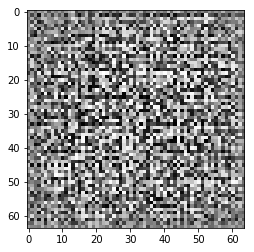

In [5]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [6]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


In [7]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[[[0.4993]]]], grad_fn=<SigmoidBackward>)


# 6.2へ
# 事前準備


1. 書籍の指示に従い、本章で使用するデータをダウンロードし、さらにフォルダ「utils」を用意する。

2. OpenCVをインストールします。

 pip install opencv-python

# GANの損失関数

In [8]:
# Dの誤差関数のイメージ実装
# maximize log(D(x)) + log(1 - D(G(z)))
# ※ xが未定義なので動作はエラー

# 正解ラベルを作成
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 偽ラベルを作成
label_fake = torch.full((mini_batch_size,), 0)

# 誤差関数を定義
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 真の画像を判定
d_out_real = D(x)

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake


NameError: name 'x' is not defined

In [9]:
# Gの誤差関数のイメージ実装
# maximize log(D(G(z)))

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
g_loss = criterion(d_out_fake.view(-1), label_real)


# DataLoaderの作成

In [10]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [11]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [12]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [13]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イタレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# 学習させる

In [14]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # ConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [15]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    # Two Time-Scale UpdateでGはDよりも学習率を小さくする
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イタレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイタレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 最後のネットワークを保存する
    torch.save(G.state_dict(), 'weights/dcgan_G_net_' +
               str(epoch) + '.pth')

    torch.save(D.state_dict(), 'weights/dcgan_D_net_' +
               str(epoch) + '.pth')

    print("総イタレーション回数:", iteration)

    return G, D


In [16]:
# 学習・検証を実行する
# 8分ほどかかる
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1085 ||Epoch_G_Loss:0.0739
timer:  2.5075 sec.
-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.1022
timer:  1.4447 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1228 ||Epoch_G_Loss:0.0998
timer:  1.4433 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0433 ||Epoch_G_Loss:0.1324
timer:  1.4455 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1012 ||Epoch_G_Loss:0.1702
timer:  1.4303 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.1960
timer:  1.4258 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.1183 ||Epoch_G_Loss:0.0756
timer:  1.4534 sec.
-------------
Epoch 7/300
-------------


-------------
epoch 60 || Epoch_D_Loss:0.1125 ||Epoch_G_Loss:0.0934
timer:  1.4591 sec.
-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.1290 ||Epoch_G_Loss:0.0957
timer:  1.4693 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.1227 ||Epoch_G_Loss:0.0933
timer:  1.4658 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.1294 ||Epoch_G_Loss:0.0930
timer:  1.4579 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.1334 ||Epoch_G_Loss:0.0925
timer:  1.4636 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.1377 ||Epoch_G_Loss:0.0932
timer:  1.4568 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.1288 ||Epoch_G_Loss:0.0856
timer:  1.4520 sec.
-------------
Epoch 67/300
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.1087 ||Epoch_G_Loss:0.1146
timer:  1.4620 sec.
-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.1005 ||Epoch_G_Loss:0.1374
timer:  1.4555 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.1130 ||Epoch_G_Loss:0.1046
timer:  1.4747 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.1102 ||Epoch_G_Loss:0.1042
timer:  1.4607 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.1070 ||Epoch_G_Loss:0.1117
timer:  1.4662 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.1014 ||Epoch_G_Loss:0.1076
timer:  1.4626 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.1014 ||Epoch_G_Loss:0.1103
timer:  1.4575 sec.
-------------
Epoch 127/300
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0894 ||Epoch_G_Loss:0.1219
timer:  1.4445 sec.
-------------
Epoch 180/300
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0833 ||Epoch_G_Loss:0.1301
timer:  1.4522 sec.
-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0986 ||Epoch_G_Loss:0.1258
timer:  1.4650 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0862 ||Epoch_G_Loss:0.1191
timer:  1.4837 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.1294
timer:  1.4499 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0944 ||Epoch_G_Loss:0.1281
timer:  1.4697 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.1300
timer:  1.4604 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 186 || 

-------------
epoch 238 || Epoch_D_Loss:0.0858 ||Epoch_G_Loss:0.1748
timer:  1.4626 sec.
-------------
Epoch 239/300
-------------
（train）
-------------
epoch 239 || Epoch_D_Loss:0.0830 ||Epoch_G_Loss:0.1567
timer:  1.4502 sec.
-------------
Epoch 240/300
-------------
（train）
-------------
epoch 240 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.1578
timer:  1.4524 sec.
-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.1571
timer:  1.5563 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:0.0691 ||Epoch_G_Loss:0.1644
timer:  1.4434 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.1680
timer:  1.4378 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.1576
timer:  1.4649 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 245 || 

-------------
epoch 297 || Epoch_D_Loss:0.0337 ||Epoch_G_Loss:0.1977
timer:  1.4602 sec.
-------------
Epoch 298/300
-------------
（train）
-------------
epoch 298 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.2205
timer:  1.4684 sec.
-------------
Epoch 299/300
-------------
（train）
-------------
epoch 299 || Epoch_D_Loss:0.0584 ||Epoch_G_Loss:0.1946
timer:  1.4650 sec.
総イタレーション回数: 2101


以上

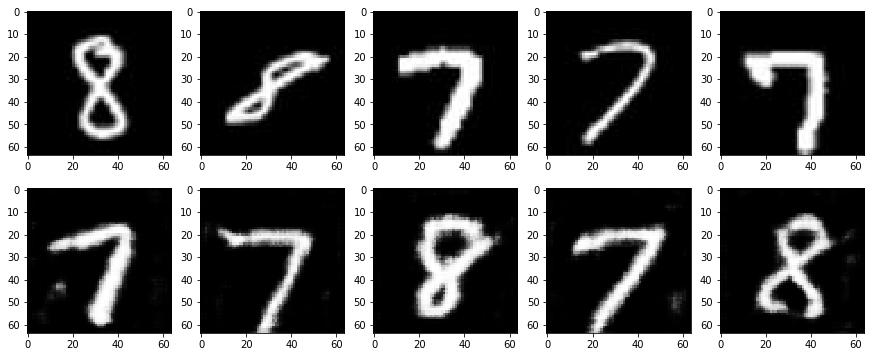

In [32]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イタレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')